In [1]:
import pickle
import matplotlib.pyplot as plt
import networkx as nx
from tqdm import tqdm

from embed_articles import embed_articles
from cosine_similarity import cosine_sim
from get_data import get_new_articles

In [11]:
data_filename = 'newsdata.json'
embeddings_filename = 'embedded_articles.pkl'
cossim_desc_filename = 'cosine_similiarties_descriptions.pkl'
cossim_title_filename = 'cosine_similiarties_titles.pkl'
embedding_variables = ['description', 'title']
run_embedding = False   # True if no local file with embeddings
run_cossim = False      # True if no local file with cosine similiarities
save_results = False    # If True, then the embeddings and cossims are saved to a file after they are run
run_new_pos = False      # True if no local file with newest positions

get_new_nodes = False # Set to true if you want to use api credits to get more data

In [3]:
# Run to use up to 30 newsdata.io credits for more articles
if get_new_nodes:
    william, bella, nicolai = 'pub_d9de26b5f5c540558489f00542c6366d', ' ', 'pub_2ffc1a6468d240ee80c80400eeea1c23'
    try:
        get_new_articles(api_key=william, data_filename=data_filename, verbose=False)
    except Exception as e:
        print('No more api credits')

In [4]:
if run_embedding:
    # Embedding all articles
    print('Running embedding')
    embedded_articles, embedding_length, num_articles = embed_articles(input_filename=data_filename, 
                                                                    embedding_variables=embedding_variables) 
    print("Size of each embedding:", embedding_length)
    print("Amount of articles reviewed:", num_articles)
    print("Amount of articles embedded:", len(embedded_articles))
    print("Finished running embedding")
    
    if save_results:
        print("Saving embeddings to file")
        with open(embeddings_filename, 'wb') as f:
            pickle.dump(embedded_articles, f)
else:
    with open(embeddings_filename, 'rb') as f:
        embedded_articles = pickle.load(f)

if run_cossim:
    # Calculating cosine similarity on titles and descriptions
    print()
    print("Running cosine similarity")
    emb_titles = []
    emb_desc = []
    for key in embedded_articles.keys():
        emb_titles.append(embedded_articles[key]['embedded_title'])
        emb_desc.append(embedded_articles[key]['embedded_description'])
    print("Running cosine similarities for titles")
    cossim_titles = cosine_sim(input_data=emb_titles)
    print("Running cosine similarities for descriptions")
    cossim_desc = cosine_sim(input_data=emb_desc)
        
    print("Finished running cosine similarity")
    
    if save_results:
        print("Saving cossims to file")
        with open(cossim_title_filename, 'wb') as f:
            pickle.dump(cossim_titles, f)
        with open(cossim_desc_filename, 'wb') as f:
            pickle.dump(cossim_desc, f)
else:
    with open(cossim_desc_filename, 'rb') as f:
        cossim_desc = pickle.load(f)
    with open(cossim_title_filename, 'rb') as f:
        cossim_titles = pickle.load(f)
        
# Getting articles without embeddings for creating attributes for nx graph
print('Extracting articles without embeddings')
all_articles = {}
for id, article in embedded_articles.items():
    article_no_embedding = article
    for var in embedding_variables:
        article_no_embedding.pop(f'embedded_{var}')
    all_articles[id] = article_no_embedding

Extracting articles without embeddings


In [5]:
num_rows = len(all_articles.keys())
num_variables = len(all_articles['2c5f9d3455e1dc5ca96c14d39bd2d61d'].keys())

print(f"Number of rows: {num_rows}\nNumber of variables: {num_variables}")

Number of rows: 2071
Number of variables: 8


In [6]:
G = nx.Graph()
G.add_nodes_from(list(all_articles.keys()))

thres = 0.3
for i in tqdm(range(len(cossim_desc)-1)):
    id_i = list(all_articles.keys())[i]
    for j in range(i+1, len(cossim_desc)):
        id_j = list(all_articles.keys())[j]
        if cossim_desc[i][j] >= thres:
            G.add_edge(id_i, id_j)

nx.set_node_attributes(G, all_articles)
H = G.subgraph(max(nx.connected_components(G), key=len))
print("Number of nodes in largest connected component:", H.number_of_nodes())
print("Number of edges in largest connected component:", H.number_of_edges())
print("Node attributes are:", list(list(H.nodes(data=True))[0][1].keys()))

100%|██████████| 2070/2070 [01:09<00:00, 29.95it/s] 

Number of nodes in largest connected component: 2033
Number of edges in largest connected component: 32710
Node attributes are: ['link', 'title', 'description', 'country', 'category', 'pubDate', 'source_id', 'source_name']


In [ ]:
if run_new_pos:
    pos = nx.forceatlas2_layout(G, max_iter=1000, scaling_ratio=2, gravity=2, linlog=True, seed=42)
    pos2 = nx.forceatlas2_layout(H, max_iter=1000, scaling_ratio=2, gravity=2, linlog=True, seed=42)
    with open('POS.pkl', 'wb') as f:    # Saving POS as for later use, as they take time to compute
        pickle.dump(pos, f)
    with open('POS2.pkl', 'wb') as f:
        pickle.dump(pos2, f)
else:
    with open('POS.pkl', 'rb') as f:    # Loading previously computed POS
        pos = pickle.load(f)
    with open('POS2.pkl', 'rb') as f:
        pos2 = pickle.load(f)

c:\Users\Nicolai\miniconda3\envs\social\Lib\site-packages\networkx\drawing\layout.py:1809: RuntimeWarning: invalid value encountered in divide
  attraction = -np.log(1 + distance) / distance


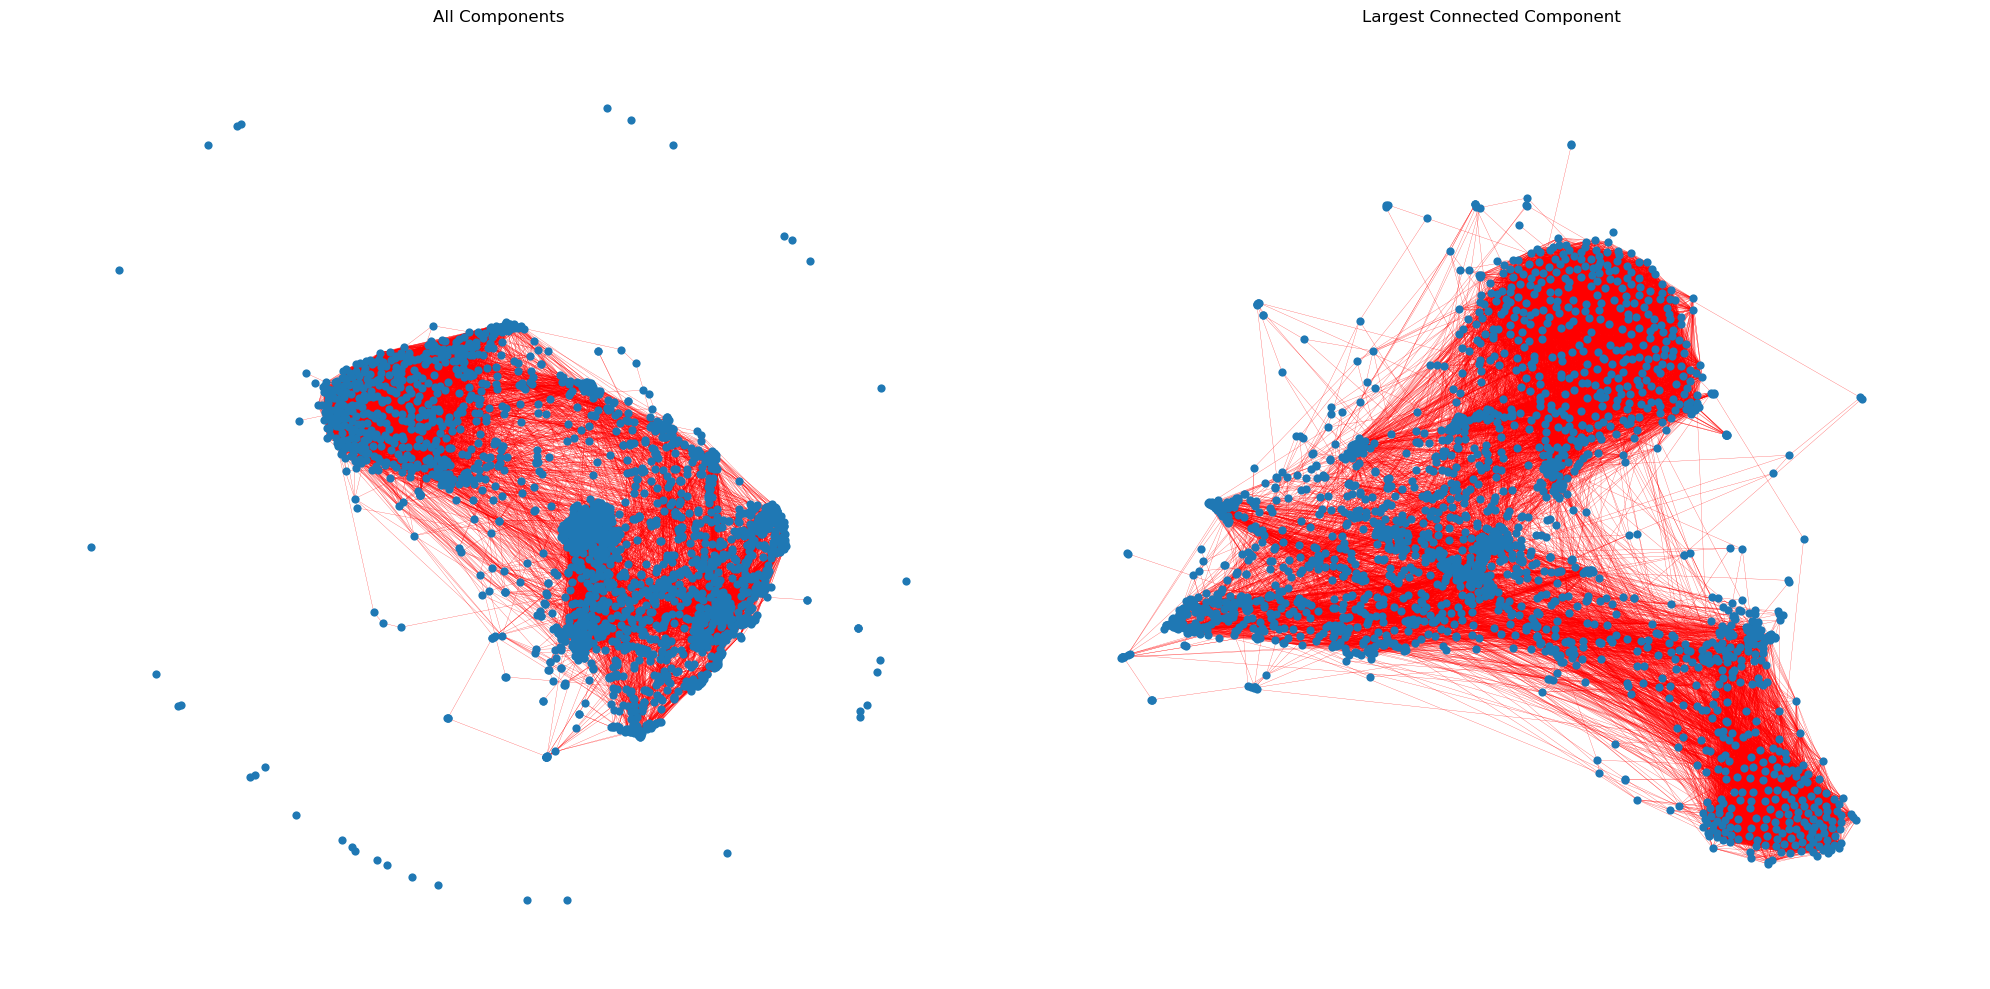

98.17% of the nodes are in the largest connected component.


In [8]:
fig, ax = plt.subplots(1,2, figsize=(20, 10))

nx.draw_networkx_nodes(G, pos, node_size=35, linewidths=0, ax=ax[0])
nx.draw_networkx_edges(G, pos, width=0.2, alpha=0.8, edge_color="red", ax=ax[0])
ax[0].margins(0.1)
ax[0].set_axis_off()
ax[0].set_title('All Components')

nx.draw_networkx_nodes(H, pos2, node_size=35, linewidths=0, ax=ax[1])
nx.draw_networkx_edges(H, pos2, width=0.2, alpha=0.8, edge_color="red", ax=ax[1])
ax[1].margins(0.1)
ax[1].set_axis_off()
ax[1].set_title('Largest Connected Component')

plt.tight_layout()
plt.show()

print(f"{round(len(H.nodes())/len(G.nodes())*100,2)}% of the nodes are in the largest connected component.")

Text(0.5, 1.0, 'Degree Distribution')

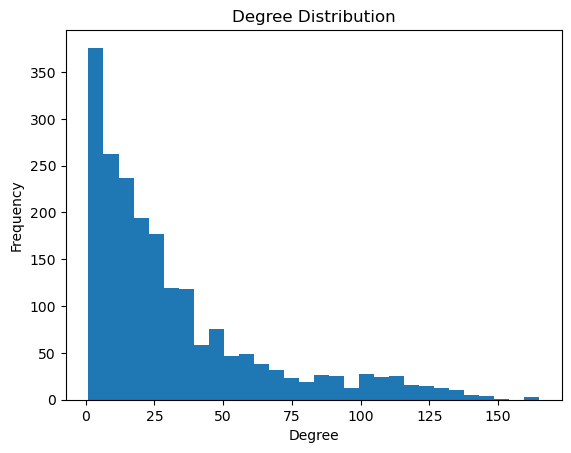

In [9]:
degrees = [H.degree(n) for n in H.nodes()]

plt.hist(degrees, bins=30)
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution')